In [1]:

#importing packages
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import fiona
from fiona import Feature, Geometry
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import rasterio as rio
from rasterio.enums import Resampling

import skgstat as skg



In [2]:
#stacked Green, Red, Red Edge, and Near Infrared band individual rasters into one multi-band raster
top_path='S:/mc5545/SA_Drone_data/'


In [3]:
raster_path1 = top_path+'burnplot18_lr/reflectance'
raster_filename1 = 'burnplot18_lr_band_stack.tif' #2006

raster_path2 = top_path+'burn2016_lr/reflectance'
raster_filename2 = 'burn2016_lr_band_stack.tif' #2016

raster_path3 = top_path+'burn2017&2016_lr/reflectance'
raster_filename3 = 'burn2017&2016_lr_band_stack.tif' #2017

raster_path4 = top_path+'burn2019_lr/reflectance'
raster_filename4 = 'burn2019_lr_band_stack.tif' #2019

raster_path5 = top_path+'burnplot17_lr/reflectance'
raster_filename5 = 'burnplot17_lr_band_stack.tif' #2020

raster_path6 = top_path+'burn2022_lr/reflectance'
raster_filename6 = 'burn2022_lr_band_stack.tif' #2022


In [4]:
shapefiles1 = gpd.read_file(Path(top_path,'burnplot18_lr/burnplot18_lr_shape_all/burnplot18_lr_shp.shp'))
shapefiles2 = gpd.read_file(Path(top_path,'burn2016_lr/burn2016_lr_shape_all/burn2016_shp.shp'))
shapefiles3 = gpd.read_file(Path(top_path,'burn2017&2016_lr/burn2017_shape/burn2017_shp.shp'))
shapefiles4 = gpd.read_file(Path(top_path,'burn2019_lr/burn2019_lr_shape_all/burn2019_lr_shp.shp'))
shapefiles5 = gpd.read_file(Path(top_path,'burnplot17_lr/burnplot17_lr_shape_all/burnplot17_lr_shp.shp'))
shapefiles6 = gpd.read_file(Path(top_path,'burn2022_lr/burn2022_lr_shape_all/burn2022_lr_shp.shp'))

In [5]:
#load raster1
def variogram_preprocess(raster_path, raster_filename, shapefiles):
    raster = rxr.open_rasterio(Path(raster_path, raster_filename),masked=True).squeeze()
    geometries = shapefiles.geometry.apply(mapping)
    
    # Create an empty list to store the clipped rasters
    clipped_rasters = []
    for i in range(len(shapefiles)):   
        # Clip the raster with the current geometry
        p1 = raster.rio.clip([geometries[i]],shapefiles.crs)
        # Convert the clipped raster to a NumPy array
        p1_np = np.asarray(p1)
        # Append the clipped raster array to the list
        clipped_rasters.append(p1_np)
        
    #order of the bands G=0, R=1, RE=2, NIR=3 for our stack
    # Create an empty list to store the indicies values for each clipped raster
    #order of the bands G=0, R=1, RE=2, NIR=3 for our stack
    # Create an empty list to store the indicies values for each clipped raster
    NDVI_values = []
    ReCI_values = []
    NDRE_values = []
    GNDVI_values =[]
    OSAVI_values= []
    GCI_values  = []
    SR_values   = []
    MSR_values  = []
    RDVI_values = []
    NDWI_values = []
    
    DVI_values   =[]
    GSAVI_values =[]
    MSAVI2_values=[]
    CVI_values   =[]
    RGRI_values  =[]
    
    # Iterate through the clipped rasters
    for p1_np in clipped_rasters:
        NDVI = (p1_np[3] - p1_np[1]) / (p1_np[3] + p1_np[1])
        ReCI = (p1_np[3] / p1_np[2])-1
        NDRE=  (p1_np[3]-p1_np[2])/(p1_np[3]+p1_np[2])
        GNDVI= (p1_np[3]-p1_np[0])/(p1_np[3]+p1_np[0])
        OSAVI= (p1_np[3]-p1_np[1])/(p1_np[3]+p1_np[1]+0.16)
        GCI=   (p1_np[3]/p1_np[0])-1
        SR=    (p1_np[3] / p1_np[1])
        MSR =  ((p1_np[3] / p1_np[1])-1)/(np.sqrt((p1_np[3] / p1_np[1])+1))
        RDVI=  np.sqrt((p1_np[3]-p1_np[1])/(p1_np[3]+p1_np[1]))
        NDWI=  (p1_np[0] - p1_np[3]) / (p1_np[0] + p1_np[3])
        
        DVI=(p1_np[3] - p1_np[1])
        GSAVI=1.5*((p1_np[3] - p1_np[0])/(p1_np[3] + p1_np[0]+0.5))
        MSAVI2=(2*p1_np[3]+1-np.sqrt((2*p1_np[3]+1)**2-8*(p1_np[3]-p1_np[1])))/2
        CVI=(p1_np[3]*p1_np[1])/(p1_np[0])**2
        RGRI=p1_np[1]/p1_np[0]
        
        
        # Append the indices value to the list
        NDVI_values.append(NDVI)
        ReCI_values.append(ReCI)
        NDRE_values.append(NDRE)
        GNDVI_values.append(GNDVI)
        OSAVI_values.append(OSAVI)
        GCI_values.append(GCI)
        SR_values.append(SR)
        MSR_values.append(MSR)
        RDVI_values.append(RDVI)
        NDWI_values.append(NDWI)
        
        DVI_values.append(DVI)
        GSAVI_values.append(GSAVI)
        MSAVI2_values.append(MSAVI2)
        CVI_values.append(CVI)
        RGRI_values.append(RGRI)
    
    # Calculate the means and standard deviations of each indices
    mean_NDVI = [np.nanmean(v) for v in NDVI_values]
    std_NDVI = [np.nanstd(v) for v in NDVI_values]

    mean_ReCI = [np.nanmean(v) for v in ReCI_values]
    std_ReCI = [np.nanstd(v) for v in ReCI_values]
    
    mean_NDRE = [np.nanmean(v) for v in NDRE_values]
    std_NDRE = [np.nanstd(v) for v in NDRE_values]
    
    mean_GNDVI= [np.nanmean(v) for v in GNDVI_values]
    std_GNDVI= [np.nanstd(v) for v in GNDVI_values]   
    
    mean_OSAVI= [np.nanmean(v) for v in OSAVI_values]
    std_OSAVI= [np.nanstd(v) for v in OSAVI_values]
    
    mean_GCI = [np.nanmean(v) for v in GCI_values]
    std_GCI = [np.nanstd(v) for v in GCI_values]
    
    mean_SR = [np.nanmean(v) for v in SR_values]
    std_SR = [np.nanstd(v) for v in SR_values]
    
    mean_MSR= [np.nanmean(v) for v in MSR_values]
    std_MSR=[np.nanstd(v) for v in MSR_values]
        
    mean_RDVI=[np.nanmean(v) for v in RDVI_values]
    std_RDVI= [np.nanstd(v) for v in RDVI_values]
    
    mean_NDWI=[np.nanmean(v) for v in NDWI_values]
    std_NDWI= [np.nanstd(v) for v in NDWI_values]
    
    mean_DVI =[np.nanmean(v) for v in DVI_values]
    mean_GSAVI =[np.nanmean(v) for v in GSAVI_values]
    mean_MSAVI2=[np.nanmean(v) for v in MSAVI2_values]
    mean_CVI =[np.nanmean(v) for v in CVI_values]
    mean_RGRI=[np.nanmean(v) for v in RGRI_values]
    

    # Assuming 'gdf' is your GeoDataFrame
    centroid =shapefiles.geometry.centroid
    #centroid.dtypes
    
    # Extract X and Y coordinates from the centroids
    df = pd.DataFrame({"x": centroid.x, 
                       "y": centroid.y,
                       "NDVI":mean_NDVI,
                       "Std_NDVI":std_NDVI,
                       "ReCI":mean_ReCI,
                       "Std_ReCI":std_ReCI,     
                       "NDRE":mean_NDRE,
                       "Std_NDRE":std_NDRE,  
                       "GNDVI":mean_GNDVI,
                       "Std_GNDVI":std_GNDVI,
                       "OSAVI":mean_OSAVI,
                       "Std_OSAVI":std_OSAVI,
                       "GCI":mean_GCI,
                       "Std_GCI":std_GCI,     
                       "SR":mean_SR,
                       "Std_SR":std_SR,
                       "MSR":mean_MSR,
                       "Std_MSR":std_MSR, 
                       "RDVI":mean_RDVI,
                       "Std_RDVI":std_RDVI,
                       "NDWI":mean_NDWI,
                       "Std_NDWI":std_NDWI,
                       
                       "DVI":mean_DVI,
                       "GSAVI":mean_GSAVI,
                       "MSAVI2":mean_MSAVI2,
                       "CVI":mean_CVI,
                       "RGRI":mean_RGRI
                      })
    return df

In [6]:
df1=variogram_preprocess(raster_path2, raster_filename2, shapefiles2)

C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [6]:
df1=variogram_preprocess(raster_path1, raster_filename1, shapefiles1)
df2=variogram_preprocess(raster_path2, raster_filename2, shapefiles2)
df3=variogram_preprocess(raster_path3, raster_filename3, shapefiles3)
df4=variogram_preprocess(raster_path4, raster_filename4, shapefiles4)
df5=variogram_preprocess(raster_path5, raster_filename5, shapefiles5)
df6=variogram_preprocess(raster_path6, raster_filename6, shapefiles6)

C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, a

In [54]:
directory_path='S:/mc5545/SA_Drone_data/variogram_preprocessed/'
# Save DataFrame to a CSV file with index
df1.to_csv(f'{directory_path}2006_burnplot18.csv')
df2.to_csv(f'{directory_path}2016_burn2016.csv')
df3.to_csv(f'{directory_path}2017_burn2017.csv')
df4.to_csv(f'{directory_path}2019_burn2019.csv')
df5.to_csv(f'{directory_path}2020_burnplot17.csv')
df6.to_csv(f'{directory_path}2022_burn2022.csv')

# Load DataFrame from the CSV file
#loaded_df = pd.read_csv(f'{directory_path}2006_burnplot18.csv', index_col=0)

# Now, loaded_df contains the data from the CSV file, including the index
#print(loaded_df)


In [43]:
# Calculation variogram :mean_Green, mean_Red; mean_RedEdge ;mean_NIR
#2006_burnplot18
V = skg.Variogram(coordinates=df1[['x', 'y']].values, values=df1['MSAVI2'].values)
print(V)



spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   21.53
Sill:              0.00
Nugget:            0.00
        


C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

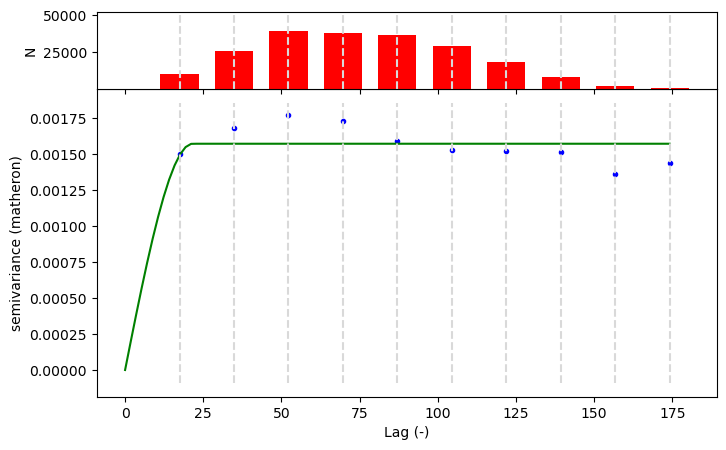

In [44]:
# Variogram visualization
V.plot()
plt.close

In [45]:
# Calculation variogram :mean_Green, mean_Red; mean_RedEdge ;mean_NIR
#2016_burn2016

V = skg.Variogram(coordinates=df2[['x', 'y']].values, values=df2['MSAVI2'].values)
print(V)


spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   46.35
Sill:              0.00
Nugget:            0.00
        


C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

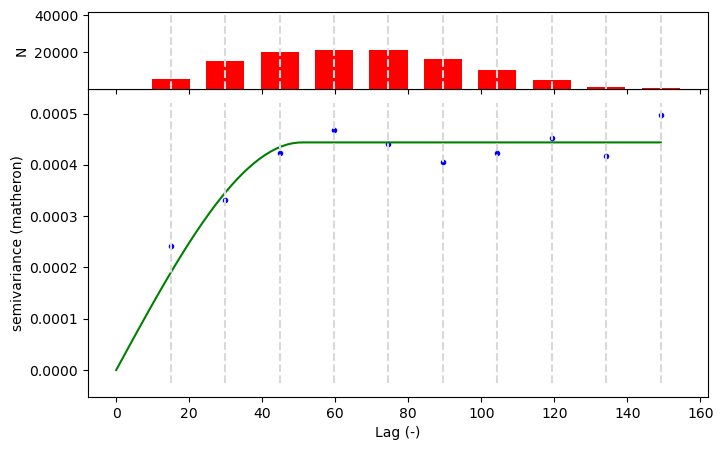

In [34]:
# Variogram visualization
V.plot()
plt.close

In [46]:
# Calculation variogram :mean_Green, mean_Red; mean_RedEdge ;mean_NIR
#2017_burn2017
V = skg.Variogram(coordinates=df3[['x', 'y']].values, values=df3['MSAVI2'].values)
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   89.02
Sill:              0.00
Nugget:            0.00
        


C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

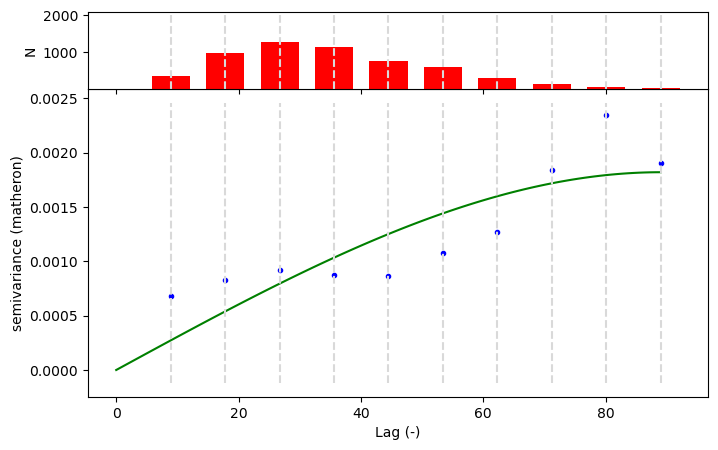

In [47]:
# Variogram visualization
V.plot()
plt.close

In [48]:
# Calculation variogram :mean_Green, mean_Red; mean_RedEdge ;mean_NIR
#2019_burn2019
V = skg.Variogram(coordinates=df4[['x', 'y']].values, values=df4['MSAVI2'].values)
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   67.42
Sill:              0.00
Nugget:            0.00
        


C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

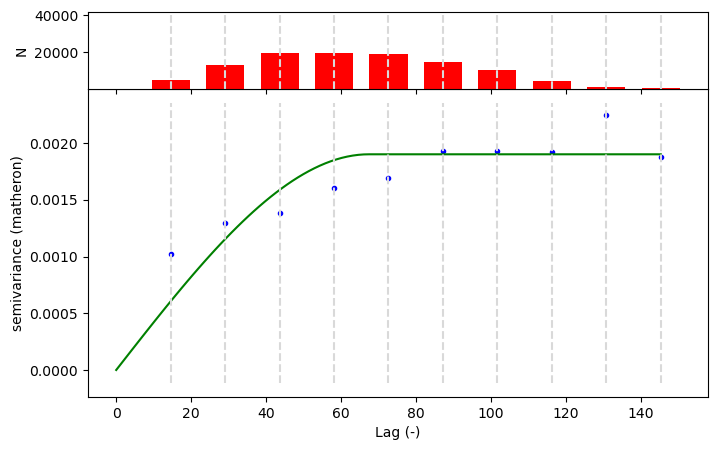

In [49]:
# Variogram visualization
V.plot()
plt.close

In [50]:
# Calculation variogram :mean_Green, mean_Red; mean_RedEdge ;mean_NIR
#2019_burn2019
V = skg.Variogram(coordinates=df5[['x', 'y']].values, values=df5['MSAVI2'].values)
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   26.22
Sill:              0.00
Nugget:            0.00
        


C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

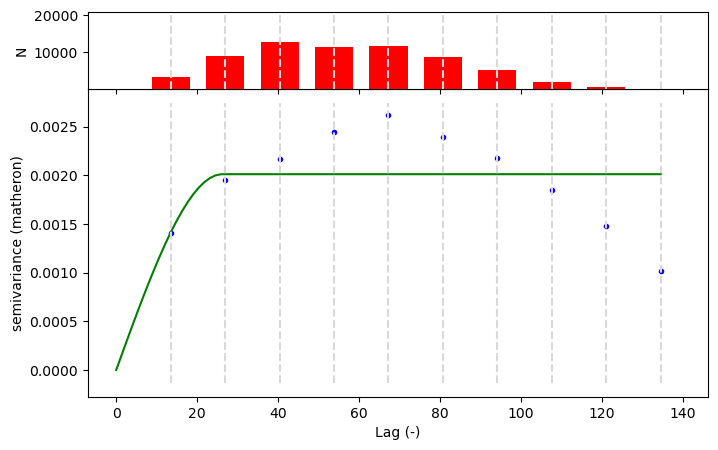

In [51]:
# Variogram visualization
V.plot()
plt.close

In [52]:
# Calculation variogram :mean_Green, mean_Red; mean_RedEdge ;mean_NIR
#2022_burn2022
V = skg.Variogram(coordinates=df6[['x', 'y']].values, values=df6['MSAVI2'].values)
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   37.04
Sill:              0.00
Nugget:            0.00
        


C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

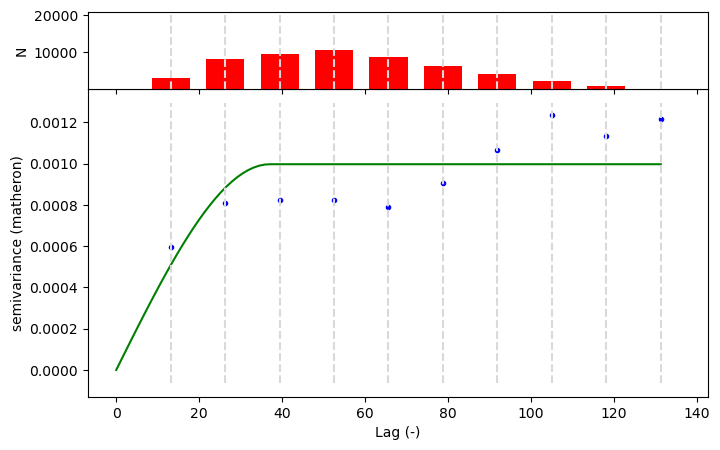

In [53]:
# Variogram visualization
V.plot()
plt.close

In [83]:
from scipy.stats import kruskal
dataframes = [df1, df2, df3, df4, df5, df6]

# Assuming dataframes is your list of dataframes
ndvi_values = [df['NDVI'].dropna().values for df in dataframes]

# Check lengths of arrays in ndvi_values
lengths = [len(arr) for arr in ndvi_values]
print(lengths)

[644, 480, 106, 460, 247, 324]


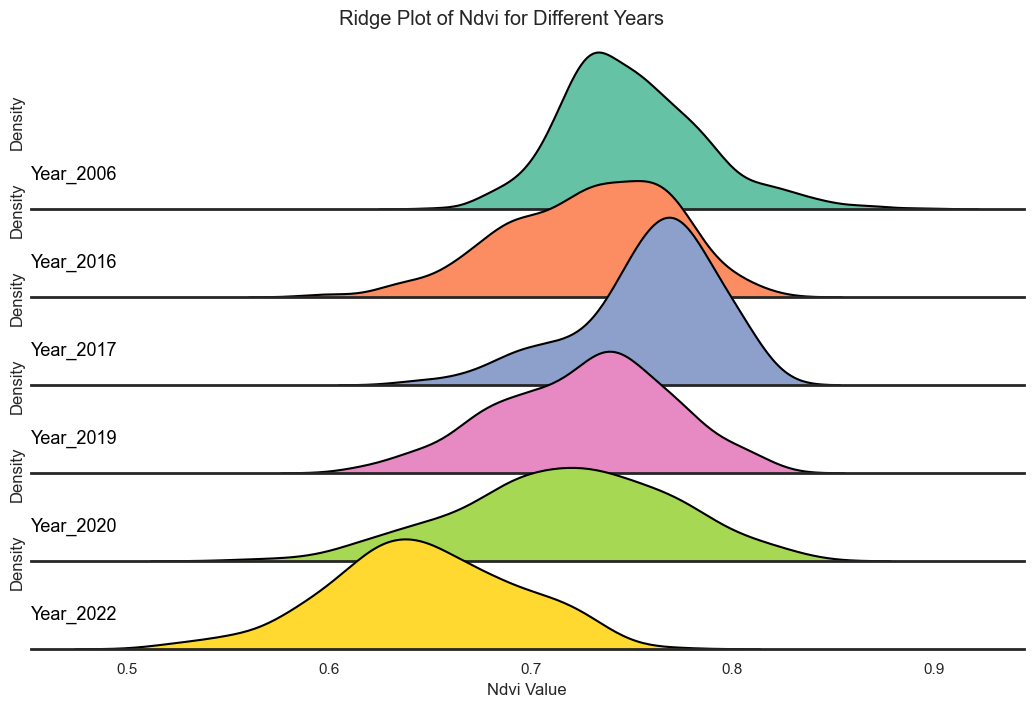

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings



def plot_ridge_histograms(dataframes, column_name, years):
    
    # Suppress warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    # Create a DataFrame for seaborn
    frames = [pd.DataFrame({'Value': df[column_name], 'Year': year}) for year, df in zip(years, dataframes)]
    data_concat = pd.concat(frames)
    
    # Set seaborn style
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})
    palette = sns.color_palette("Set2", 6)
    # Create a FacetGrid
    g = sns.FacetGrid(data_concat, palette=palette, row="Year", hue="Year", aspect=9, height=1.2)
    # Map the ridge plot
    g.map_dataframe(sns.kdeplot, x="Value", fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x="Value", color='black')
    
    # Define a function to label the plots
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color='black', fontsize=13, ha="left", va="center", transform=ax.transAxes)
    # Apply the labels
    g.map(label, "Year")
    # Adjust layout
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], xlabel=f"{column_name.capitalize()} Value")
    g.despine(left=True)
    
    # Set the main title
    plt.suptitle(f'Ridge Plot of {column_name.capitalize()} for Different Years', y=0.98)
    
    # Show the plot
    plt.show()

# Assuming dataframes is a list of your 6 DataFrames and 'NDVI' is the column

# Example usage
column_name = 'NDVI'
dataframes = [df1, df2, df3, df4, df5,df6]
years = ['Year_2006', 'Year_2016', 'Year_2017', 'Year_2019', 'Year_2020', 'Year_2022']
plot_ridge_histograms(dataframes, 'NDVI', years)

In [85]:
from scipy.stats import kruskal
dataframes = [df1, df2, df3, df4, df5, df6]

# Assuming dataframes is your list of dataframes
ndvi_values = [df['NDVI'].dropna().values for df in dataframes]

# Perform Kruskal-Wallis test
stat, p_value = kruskal(*ndvi_values)
print(f'Kruskal-Wallis Test - Statistic: {stat}, p-value: {p_value}')

Kruskal-Wallis Test - Statistic: 720.2137615308369, p-value: 2.0911610541541901e-153


Kruskal-Wallis Test - Statistic: 720.2137615308369, p-value: 2.0911610541541901e-153
One-way ANOVA - Statistic: 292.36535861633905, p-value: 1.417987904195757e-241
posthoc_mannwhitney test:               1             2             3             4             5  \
1   1.000000e+00  1.222615e-13  5.824738e-04  4.464248e-17  3.060758e-18   
2   1.222615e-13  1.000000e+00  5.814967e-12  2.872052e-01  2.891588e-03   
3   5.824738e-04  5.814967e-12  1.000000e+00  3.125818e-13  3.708804e-13   
4   4.464248e-17  2.872052e-01  3.125818e-13  1.000000e+00  2.741416e-02   
5   3.060758e-18  2.891588e-03  3.708804e-13  2.741416e-02  1.000000e+00   
6  2.336969e-125  2.722080e-84  1.059532e-47  2.551790e-79  4.008786e-45   

               6  
1  2.336969e-125  
2   2.722080e-84  
3   1.059532e-47  
4   2.551790e-79  
5   4.008786e-45  
6   1.000000e+00  


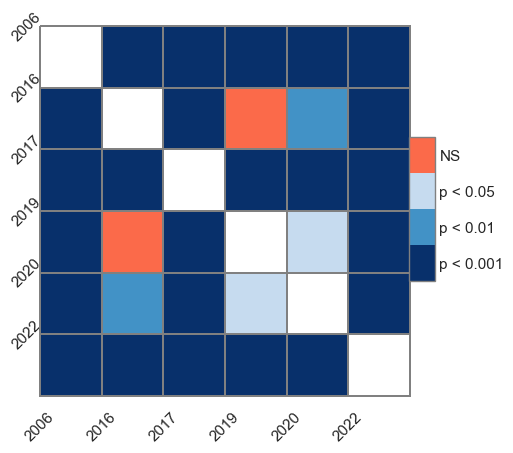

In [87]:
def statistical_test(dataframes,column_name):
    
    # Assuming dataframes is your list of dataframes
    VI_values = [df[column_name].dropna().values for df in dataframes]
    
    from scipy.stats import kruskal
    # Perform Kruskal-Wallis test
    stat, p_value = kruskal(*VI_values)
    print(f'Kruskal-Wallis Test - Statistic: {stat}, p-value: {p_value}')
    
    from scipy.stats import f_oneway
    # Perform one-way ANOVA
    stat, p_value = f_oneway(*VI_values)
    print(f'One-way ANOVA - Statistic: {stat}, p-value: {p_value}')
    
    #Non parametric
    from scikit_posthocs import posthoc_mannwhitney
    # Assuming df_list is your list of dataframes
    posthoc_results1 = posthoc_mannwhitney(VI_values)
    print(f'posthoc_mannwhitney test:{posthoc_results1}')
    
    import scikit_posthocs as sp
    years = ['2006', '2016', '2017', '2019', '2020', '2022']
    # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
    cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
    heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 
                    'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    ax,cbar=sp.sign_plot(posthoc_results1, **heatmap_args)
    # Set x-ticks and y-ticks
    ax.set_xticks(range(len(years)))
    ax.set_xticklabels(years, rotation=45,ha='center')

    ax.set_yticks(range(len(years)))
    ax.set_yticklabels(years,rotation=45,ha='center')
    # Show the plot
    plt.show()

    
dataframes = [df1, df2, df3, df4, df5, df6]
column_name='NDVI'
statistical_test(dataframes, 'NDVI')

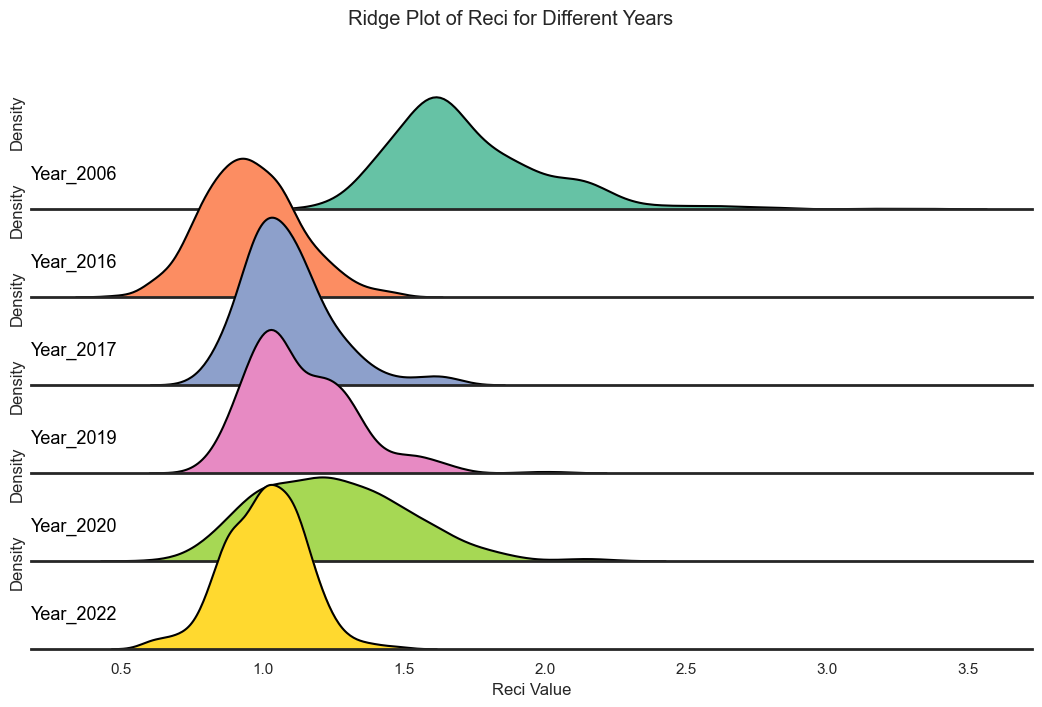

In [88]:
plot_ridge_histograms(dataframes, 'ReCI', years)

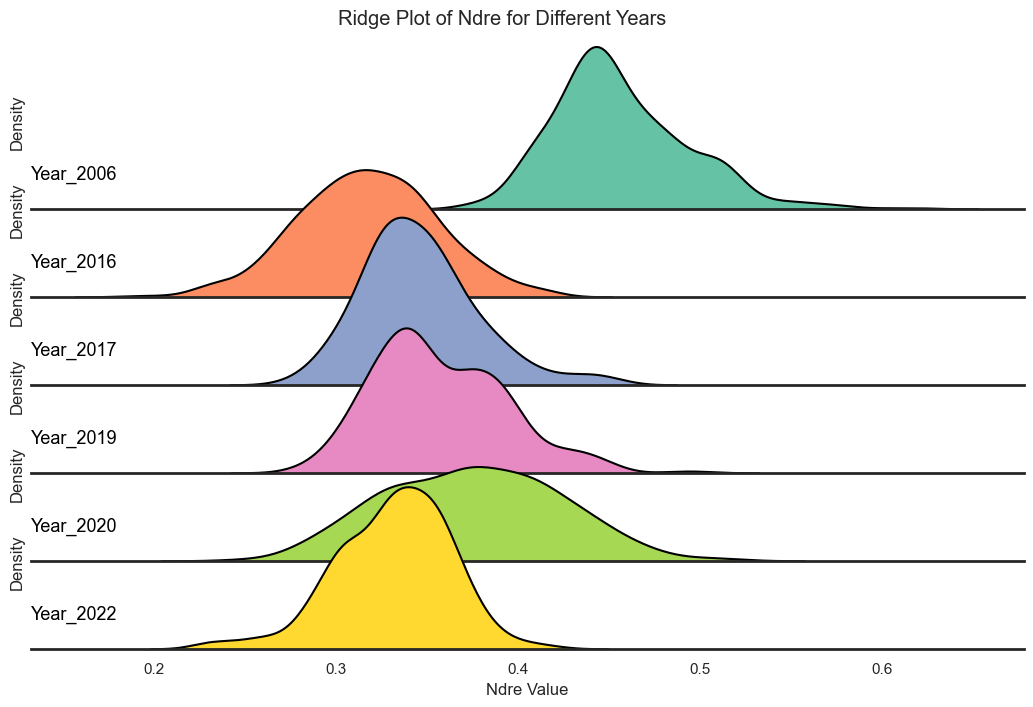

In [89]:
plot_ridge_histograms(dataframes, 'NDRE', years)

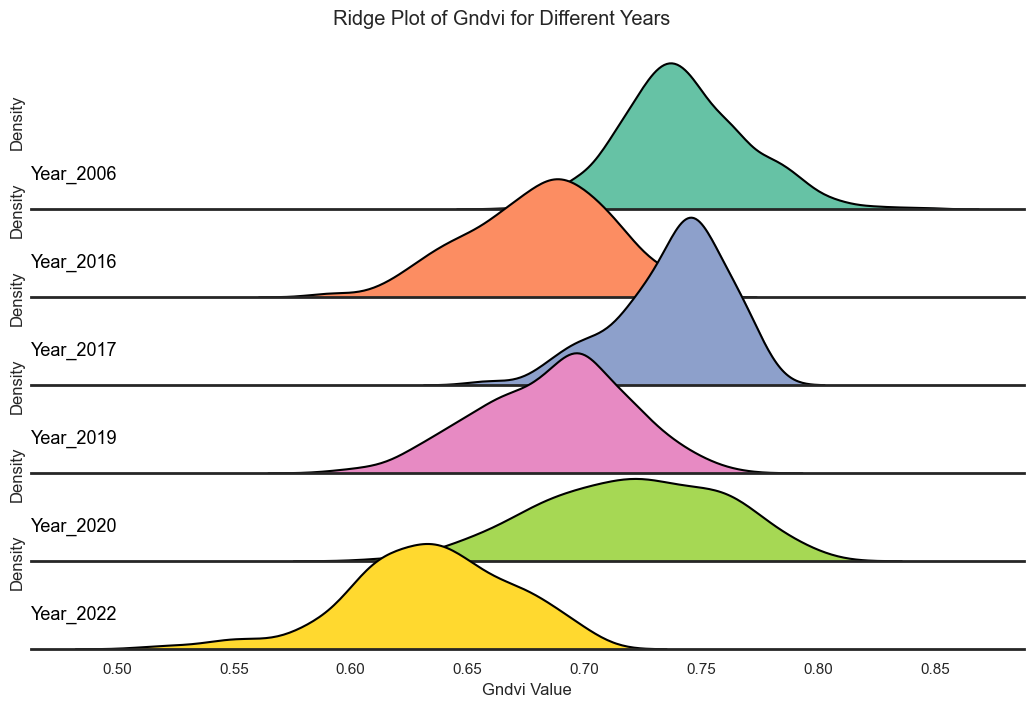

In [90]:
plot_ridge_histograms(dataframes, 'GNDVI', years)

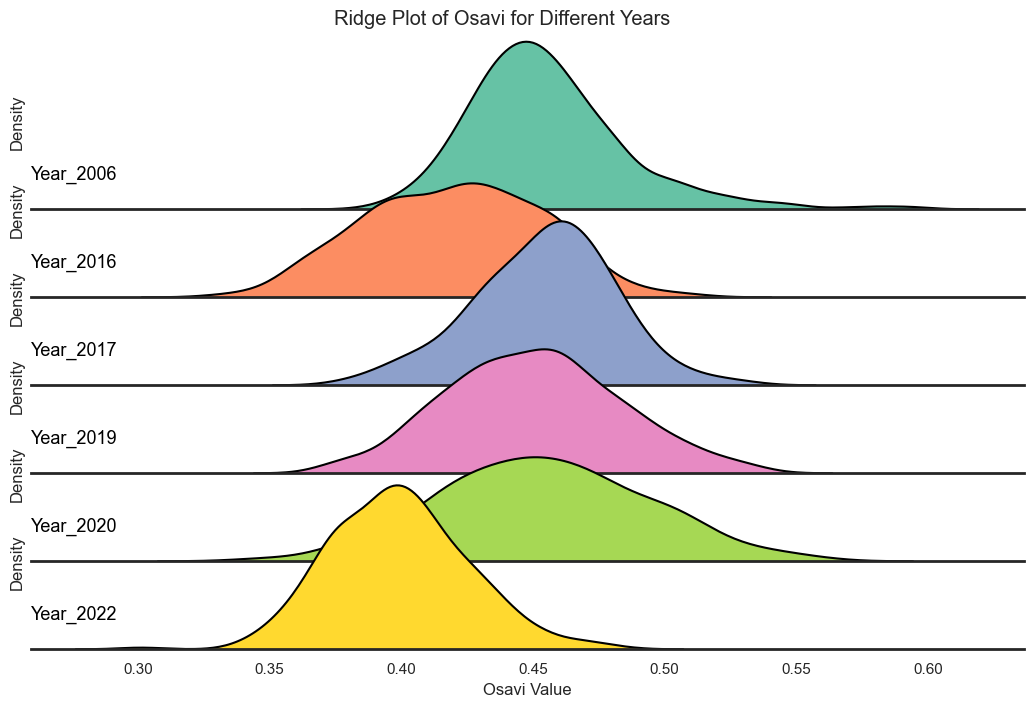

In [91]:
plot_ridge_histograms(dataframes, 'OSAVI', years)

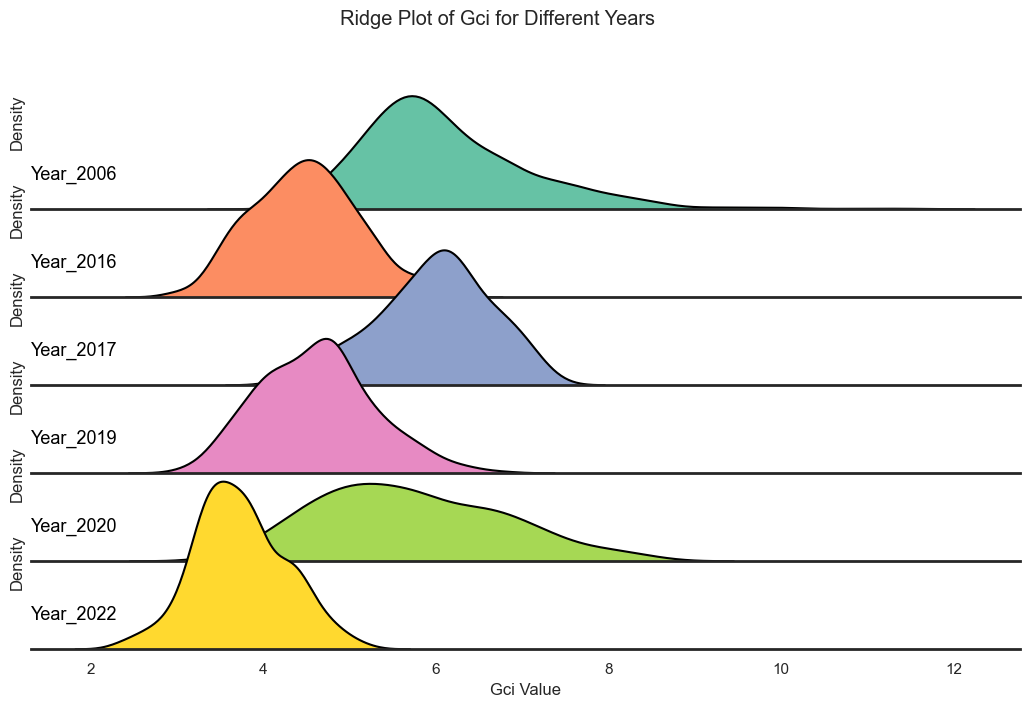

In [92]:
plot_ridge_histograms(dataframes, 'GCI', years)

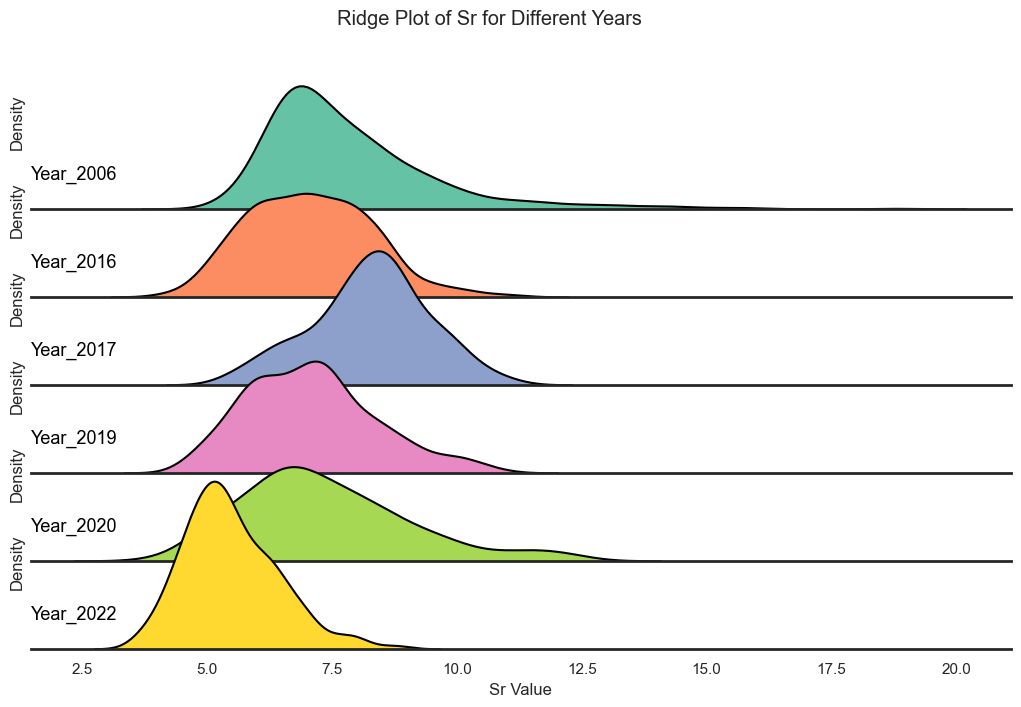

In [93]:
plot_ridge_histograms(dataframes, 'SR', years)

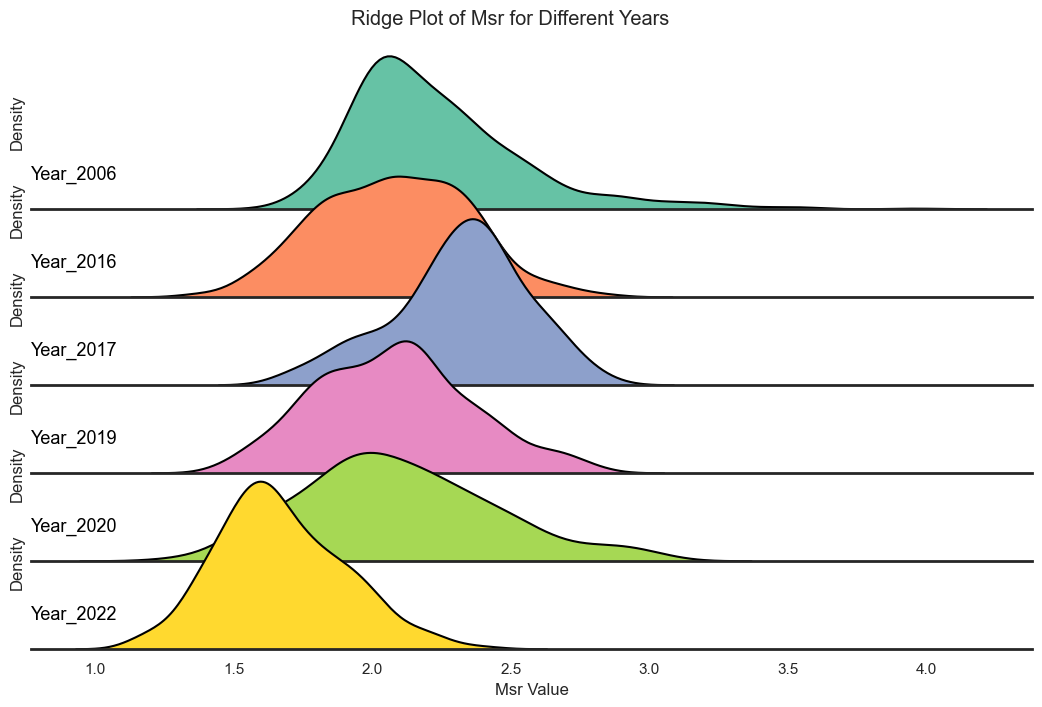

In [94]:
plot_ridge_histograms(dataframes, 'MSR', years)

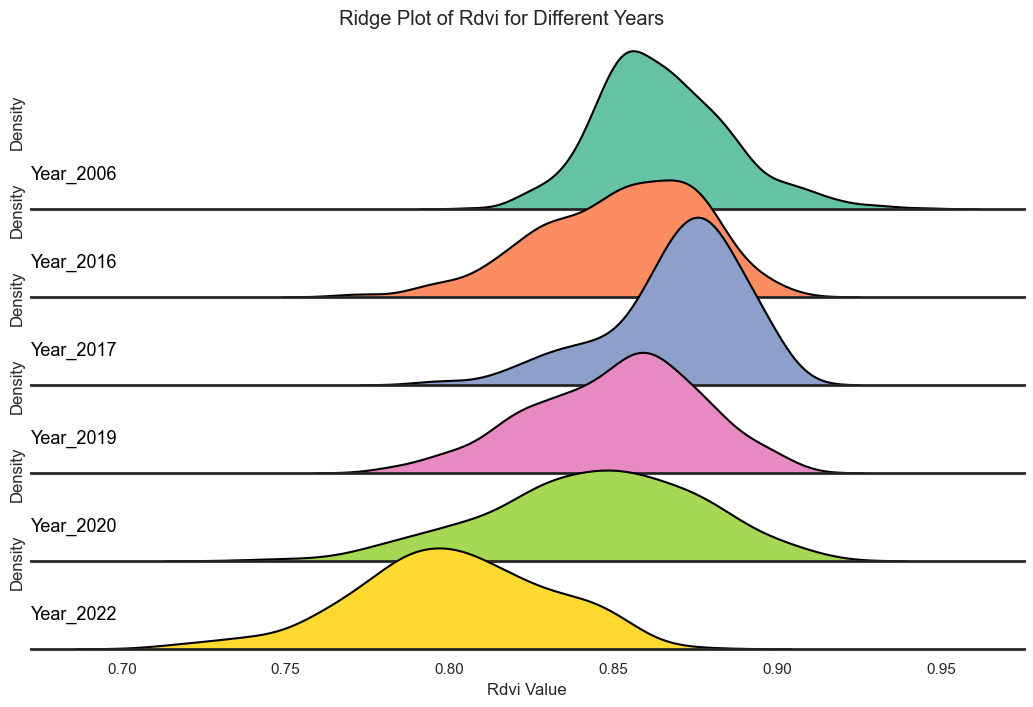

In [95]:
plot_ridge_histograms(dataframes, 'RDVI', years)

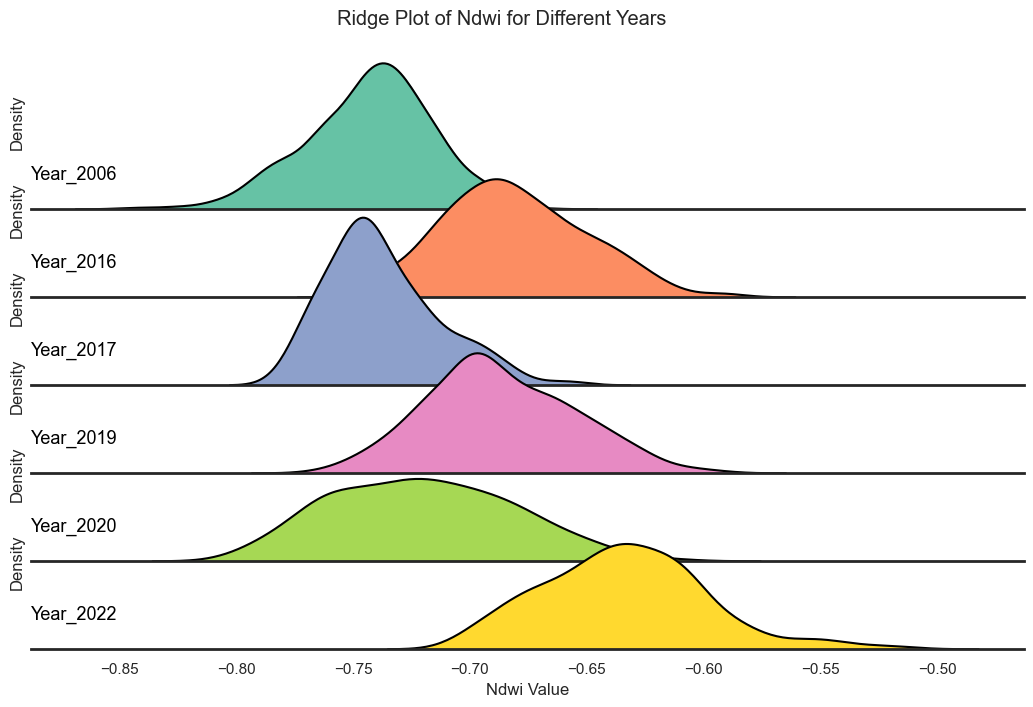

In [97]:
plot_ridge_histograms(dataframes, 'NDWI', years)